In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os
sys.path.append('..')

import horus.horus as ho

ModuleNotFoundError: No module named 'horus.horus'; 'horus' is not a package

In [2]:
bs, bsh, (nfp, coils, ma, sc_fieldline) = ho.ncsx()

#### Finding fix-point

In [17]:
fig = pickle.load(open("../output/NCSX_poincare.pkl", "rb"))
ax = fig.get_axes()[0]
plt.show()

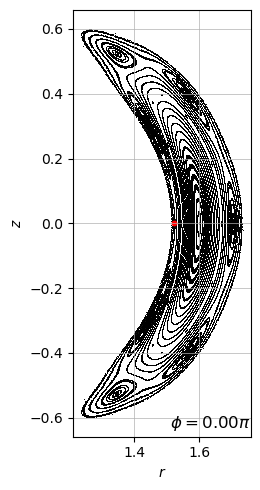

In [4]:
guess = [1.523, 0.]
ax.scatter(guess[0], guess[1], c='r', s=10)
fig

In [5]:
ps_cart = ho.SimsoptBfieldProblem(ma.gamma()[0, 0], 0, 3, bs)

In [ ]:
### Simsopt magnetic field problem class ###
from pyoculus.problems import CylindricalBfield, CartesianBfield

class SimsoptBfieldProblem(CylindricalBfield):
    def __init__(self, R0, Z0, Nfp, bs):
        super().__init__(R0, Z0, Nfp)

        self.bs = bs

    # The return of the B field for the two following methods is not the same as the calls are :
    #   - CartesianBfield.f_RZ which does :
    #   line 37     B = np.array([self.B(xyz, *args)]).T
    #   - CartesianBfield.f_RZ_tangent which does :
    #   line 68     B, dBdX = self.dBdX(xyz, *args)
    #   line 69     B = np.array(B).T
    # and both should result in a (3,1) array
    def B(self, xyz):
        xyz = np.reshape(xyz, (-1, 3))
        self.bs.set_points_cyl(xyz)
        return (CartesianBfield._inv_Jacobian(xyz[0][0], xyz[0][1], xyz[0][2]) @ self.bs.B().T).flatten()

    def dBdX(self, xyz):
        B = self.B(xyz)
        P = CartesianBfield._inv_Jacobian(xyz[0], xyz[1], xyz[2])
        return [B], (P @ self.bs.dB_by_dX() @ np.linalg.inv(P)).reshape(3, 3)

ps_cyl = SimsoptBfieldProblem(ma.gamma()[0, 0], 0, 3, bs)

In [ ]:
A = ps_cart.f_RZ_tangent(0, [1.527, 0., 1.59901829, 0.,3.14159265, 1., 0., 0., 1.])

In [ ]:
B = ps_cyl.f_RZ_tangent(0, [1.527, 0., 1.59901829, 0.,3.14159265, 1., 0., 0., 1.])

In [ ]:
print(A-B)

In [6]:
from pyoculus.solvers import FixedPoint

# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-12

pparams = dict()
pparams["nrestart"] = 0
pparams["tol"] = 1e-10
pparams['niter'] = 100

fp = FixedPoint(ps_cart, pparams, integrator_params=iparams)
fp.compute(guess=guess, pp=3, qq=7, sbegin=1.4, send=2.0)

# [ 6.73784599e-18  2.59536476e-01  1.06389782e-16 -7.92994219e-01 -1.27375450e+00  6.18494611e-18]

0 - [DeltaR, DeltaZ] : [-0.00156006 -0.03787668] - dtheta : 0.4536325627885507
0 - [StepR, StepZ]: [ 0.00366015 -0.01617519]
1 - RZ : [ 1.52666015 -0.01617519] - rhotheta : [ 0.07414403 -2.92166501]
1 - [DeltaR, DeltaZ] : [-0.00028164 -0.00186412] - dtheta : 0.022783092172875552
1 - [StepR, StepZ]: [0.00051003 0.01275138]
2 - RZ : [ 1.52717018 -0.00342381] - rhotheta : [ 0.07192964 -3.09397523]
2 - [DeltaR, DeltaZ] : [-3.09713432e-05  1.20749501e-03] - dtheta : 0.017553361757216113
2 - [StepR, StepZ]: [-0.00014825  0.00398034]
3 - RZ : [1.52702193e+00 5.56530263e-04] - rhotheta : [0.07199851 3.13386283]
3 - [DeltaR, DeltaZ] : [7.93426611e-06 1.12507910e-04] - dtheta : 0.0023241616264320086
3 - [StepR, StepZ]: [-9.25030500e-06 -5.66093341e-04]
4 - RZ : [ 1.52701268e+00 -9.56307765e-06] - rhotheta : [ 0.07200561 -3.14145984]
4 - [DeltaR, DeltaZ] : [-1.10289505e-07  2.34657711e-06] - dtheta : 0.0007928112411779153
4 - [StepR, StepZ]: [-3.4486650e-07  9.5657494e-06]
5 - RZ : [1.52701234e+0

In [7]:
results = [list(p) for p in zip(fp.x, fp.y, fp.z)]

In [8]:
results

[[1.5270123355595129, 0.0, -1.8499625298625614e-11],
 [1.3628741066538061, 0.0, -0.4522832613908534],
 [1.4409818526057978, 0.0, -0.49453036472536327],
 [1.664201921992428, 0.0, -0.21187336521171685],
 [1.6642019219847466, 0.0, 0.2118733652332106],
 [1.44098185259326, 0.0, 0.4945303647323089],
 [1.362874106659116, 0.0, 0.4522832613801623],
 [1.5270123355594885, 0.0, -1.865928809033357e-11]]

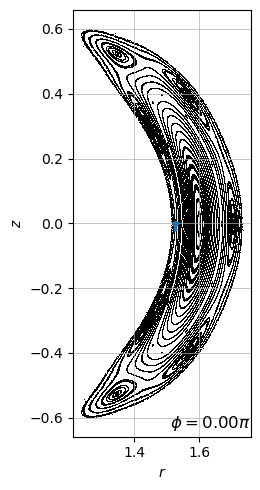

In [18]:
hist = np.array(fp.history)
ax.plot(hist[:, 0], hist[:, 1], marker = 'o', markersize = 2)
fig

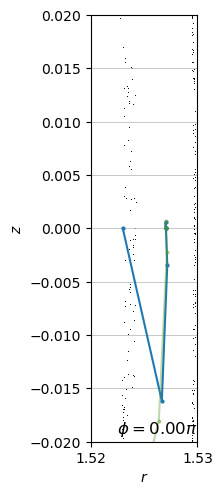

In [21]:
hist_R = np.array(fp.history_Revolved)
ax.plot(hist_R[:, 0], hist_R[:, 1], marker = 'o', markersize = 2, alpha = 0.3)
fig

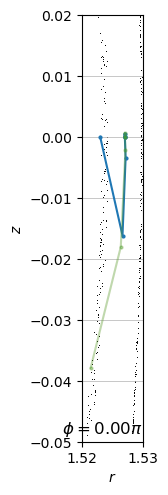

In [26]:
ax.set_xlim(1.52, 1.53)
ax.set_ylim(-0.05, 0.02)
ax.scatter(fp.x[0])
fig

In [32]:
from pyoculus.integrators import RKIntegrator

iparams = dict()
iparams["rtol"] = 1e-10
iparams["ode"] = ps_cart.f_RZ_tangent

integrator = RKIntegrator(iparams)

# initpoint = np.array([fp.x[0], fp.z[0]])
R = np.random.uniform(1.5, 1.7)
Z = np.random.uniform(-0.6, 0.7)
initpoint = np.array([R, Z])
print(initpoint)
v = 2e-5*np.random.random(2)

ic = np.array([initpoint[0], initpoint[1], 1.0, 0.0, 0.0, 1.0], dtype=np.float64)
integrator.set_initial_value(0, ic)
M = integrator.integrate(2*np.pi)
endpoint1 = M[0:2]
M = np.array([[M[2], M[4]],[M[3], M[5]]])
print(M)
print(np.linalg.det(M))

inputpoint = initpoint + v
ic = np.array([inputpoint[0], inputpoint[1], 1.0, 0.0, 0.0, 1.0], dtype=np.float64)
integrator.set_initial_value(0, ic)
endpoint2 = integrator.integrate(2*np.pi)[0:2]

print(((M @ v) - (endpoint2 - endpoint1))/np.linalg.norm(endpoint2 - endpoint1))

[1.61240475 0.47393868]
[[-2.89841986 -3.67689844]
 [-1.04389583 -1.61756303]]
0.8500778842670841
[-0.00052299 -0.00027841]


In [ ]:
for rr in results:
    ax.scatter(rr[0], rr[2], marker="X", edgecolors="black", linewidths=1)
fig

In [ ]:
from pyoculus.integrators import RKIntegrator

iparams = dict()
iparams["rtol"] = 1e-10
iparams["ode"] = ps_cart.f_RZ_tangent

integrator = RKIntegrator(iparams)

In [ ]:
initpoint = np.array([1.5, 0.2])
v = 0.0001*np.array([0, 1])

In [ ]:
ic = np.array([initpoint[0], initpoint[1], 1.0, 0.0, 0.0, 1.0], dtype=np.float64)
integrator.set_initial_value(0, ic)
M = integrator.integrate(2*np.pi)
endpoint1 = M[0:2]
M = M[2:6].reshape((2,2)).T
print(M)

In [ ]:
inputpoint = initpoint + v
ic = np.array([inputpoint[0], inputpoint[1], 1.0, 0.0, 0.0, 1.0], dtype=np.float64)
integrator.set_initial_value(0, ic)
endpoint2 = integrator.integrate(2*np.pi)[0:2]

In [ ]:
M @ v

In [ ]:
endpoint2 - endpoint1

In [ ]:
from pyoculus.integrators import RKIntegrator

iparams = dict()
iparams["rtol"] = 1e-10
iparams["ode"] = ps_cyl.f_RZ_tangent

integrator = RKIntegrator(iparams)

In [ ]:
initpoint = np.array([1.5, 0.2])
v = 0.0001*np.array([0, 1])

In [ ]:
ic = np.array([initpoint[0], initpoint[1], 1.0, 0.0, 0.0, 1.0], dtype=np.float64)
integrator.set_initial_value(0, ic)
M = integrator.integrate(2*np.pi)
endpoint1 = M[0:2]
M = M[2:6].reshape((2,2)).T
print(M)

In [ ]:
inputpoint = initpoint + v
ic = np.array([inputpoint[0], inputpoint[1], 1.0, 0.0, 0.0, 1.0], dtype=np.float64)
integrator.set_initial_value(0, ic)
endpoint2 = integrator.integrate(2*np.pi)[0:2]

In [ ]:
M @ v

In [ ]:
endpoint2 - endpoint1